<a href="https://colab.research.google.com/github/Servat0r/ISPR-Midterms-2023/blob/master/Midterm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 2 ISPR 2023 - Assignment 2 - Salvatore Correnti (matr. 584136)
In this assignment we will implement and test a simple image understanding application based on the `Latent Dirichlet Allocation` model applied to images.

## Initial Imports
As in the first assignment, before any coding we reserve a couple of cells for changing working directory and for all needed imports.

In [1]:
%cd "/content/drive/MyDrive/Colab Notebooks/ISPR-Midterms-2023"

/content/drive/MyDrive/Colab Notebooks/ISPR-Midterms-2023


In [11]:
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation as LDA  # We use the one by scikit-learn
from sklearn.cluster import KMeans
import cv2
import os
from PIL import Image
from typing import *
import math
import matplotlib.pyplot as plt
from time import perf_counter

## Latent Dirichlet Allocation for Image Understanding
`Latent Dirichlet Allocation (LDA)` is a generative model that is used for discovering categories (called `topics`) from a set of `documents` composed of `words` and to classify those documents mixtures of those topics with one `"main" topic`.

The terms `documents`, `words` and `topics` come from the fact that this model has been used mainly in the field of `Natural Language Processing` for document classification and tagging, using text corpora as training data, since this model is well suited for dealing with `atomic` units that have a semantic and appear in multiple documents.

In this notebook we will implement and test a simple application of `LDA` to the field of `Computer Vision`, in particular for `Image Understanding`.

### Latent Dirichlet Allocation
TODO: Brief description of LDA

### Bag of Visual Words Model
TODO: Description of BOVW Model

#### 0.    Utility Functions
Before proceeding in the implementation of `BOVW` model, we define some utilities for operating with images.

In [37]:
def pil_load_image(dir_path: str, file_name: str, to_grayscale=False) -> Image.Image:
  pil_image = Image.open(os.path.join(dir_path, file_name))
  return pil_image.convert('L') if to_grayscale else pil_image

def cv2_load_image(dir_path: str, file_name: str, to_grayscale=False) -> np.ndarray:
  cv2_image = cv2.imread(os.path.join(dir_path, file_name))
  if (len(cv2_image.shape) > 1) and to_grayscale:
    return cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
  else:
    return cv2_image

In [52]:
def cv2_to_pil(img_array: np.ndarray):
  mode = cv2.COLOR_BGR2RGB if len(img_array.shape) == 3 else None
  if mode is not None:
    pil_img_array = cv2.cvtColor(img_array, mode)
  else:
    pil_img_array = img_array
  pil_img = Image.fromarray(pil_img_array)
  return pil_img, pil_img_array

def pil_to_cv2(img: Union[Image.Image, np.ndarray]):
  img_array = np.asarray(img) if isinstance(img, Image.Image) else img
  mode = cv2.COLOR_RGB2BGR if len(img_array.shape) == 3 else None
  if len(img_array.shape) == 3: #mode is not None:
    print('nia')
    cv2_img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
  else:
    cv2_img_array = img_array
  return cv2_img_array

def ensure_grayscale(img: Union[Image.Image, np.ndarray], mode='BGR'):
  if isinstance(img, Image.Image):
    return img if img.mode == 'L' else img.convert('L')
  elif isinstance(img, np.ndarray):
    code = cv2.COLOR_BGR2GRAY if mode == 'BGR' else cv2.COLOR_RGB2GRAY
    return cv2.cvtColor(img, code)

Finally, for plotting results on multiple rows/columns:

In [5]:
def plot_results(
    images: Union[Image.Image, list[Image.Image]],
    show=True, figsize_scale_factor=1,
    images_per_row=None, images_per_column=None,
  ):
  if isinstance(images, Image.Image):
    images = [images]
  if (images_per_row is None) or (images_per_column is None):
    images_per_row, images_per_column = len(images), 1
  elif (images_per_row * images_per_column != len(images)):
    raise ValueError(
      f"Mismatch between (images_per_row = {images_per_row}, " \
      f"images_per_column = {images_per_column}) and len(images): " \
      f"{images_per_row * images_per_column} vs {len(images)}"
    )
  n = len(images)
  # (6.4, 4.8) are the default values for figsize in matplotlib
  figsize = (figsize_scale_factor * 6.4, figsize_scale_factor * 4.8)
  fig, ax = plt.subplots(images_per_column, images_per_row, figsize=figsize)
  if n == 1:
    ax = np.array([ax]).reshape((1, 1))  # Uniforming with the case of n > 1
  if len(ax.shape) == 1:
    ax = np.reshape(ax, (1, len(ax)))
  for i in range(images_per_column):
    for j in range(images_per_row):
      ax[i, j].imshow(images[i * images_per_row + j], interpolation='nearest', cmap='gray')
      ax[i, j].plot()
  if show:
    plt.show()

#### 1. SIFT Feature Extraction
We will use the implementation of `SIFT` feature extractor available in `OpenCV` to detect **both** *interest points* and their *descriptors*.

In [62]:
def apply_sift(img_array: np.ndarray):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(img_array, None)
  return keypoints, descriptors

def draw_keypoints(img_array: np.ndarray, keypoints, class_ids=False):
  if class_ids:
    i = 0
    while True:
      id_kp = [keypoint for keypoint in keypoints if keypoint.class_id == i]
      if len(id_kp) == 0:
        break
      #i_str = hex((43 * i + 1) % 256)[2:]
      img_array = cv2.drawKeypoints(img_array, id_kp, None, (43 * i + 1) % 256)# f"0x{i_str}{i_str}{i_str}")
      i += 1
    print(f"********{i}********")
    return img_array
  else:
    return cv2.drawKeypoints(img_array, keypoints, None)

And now an example:

(125, 128)


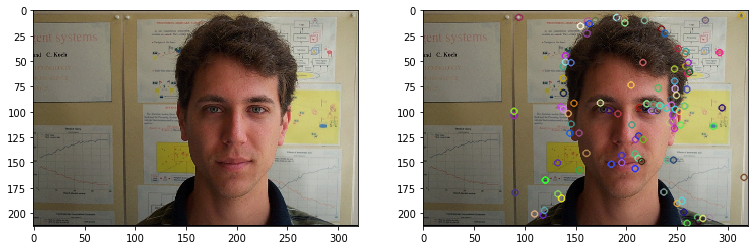

In [35]:
dir_path = 'MSRC_ObjCategImageDatabase_v1'
file_name = '6_4_s.bmp'
# Load images
pil_rgb_image = pil_load_image(dir_path, file_name)
cv2_bgr_image = cv2_load_image(dir_path, file_name)
cv2_gray_image = cv2.cvtColor(cv2_bgr_image, cv2.COLOR_BGR2GRAY)
# Extract features
keypoints, descriptors = apply_sift(cv2_gray_image)
print(descriptors.shape)
# Draw keypoints and convert to PIL
cv2_bgr_image_keypoints = draw_keypoints(cv2_bgr_image, keypoints)
pil_rgb_image_keypoints, _ = cv2_to_pil(cv2_bgr_image_keypoints)
# Show original and keypoints images
plot_results(
    [pil_rgb_image, pil_rgb_image_keypoints], figsize_scale_factor=2,
)

#### 2. Dataset
We will use the same dataset as in `Midterm 1`:

http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

In this case we will use the whole dataset for training and testing. Since we want to have *reproducible* experiments, we will implement a sampling procedure from the whole dataset s.t. we can pass a seed to *always* get the *same* dataset each time we run this notebook.

In [8]:
def train_test_split(
    dir_path: str, test_images_per_category: int = 1,
    random_state: Union[int, None] = None,
):
  filenames = os.listdir(dir_path)
  filenames = [filename for filename in filenames if ('GT' not in filename) and ('bmp' in filename)]
  filenames_by_category = {str(i): [] for i in range(1, 9)}
  for filename in filenames:
    filenames_by_category[filename[0]].append(filename)

  for k, v in filenames_by_category.items():
    filenames_by_category[k] = sorted(v, key=lambda x: int(x.split('_')[1]))

  rng = np.random.default_rng(random_state)

  train_images = []
  test_images = []

  for i in range(test_images_per_category):
    indexes = rng.integers(30-i, size=8)
    for j in range(1, 9):
      v = filenames_by_category[str(j)]
      test_images.append(v.pop(indexes[j-1]))

  for i in range(1, 9):
    train_images += filenames_by_category[str(i)]
  
  return train_images, test_images

#### 3. Building the codebook
The next step is to build a `codebook` from the SIFT descriptors extracted from training images. A `codebook` is a vocabulary that indexes visual words such that each SIFT descriptor can be assigned a word in the codebook itself. In other terms, we will *cluster* the SIFT descriptors extracted from the training images into $k$ clusters and our codebook will contain a representative word for each of the $k$ clusters.

In our case, we will use `KMeans` as clustering algorithm and we will save each of the $k$ `centroids` found by KMeans as representative words.

In [67]:
class Codebook:
  def __init__(
      self, dir_path, train_images_filenames: list[str],
      n_clusters=10, max_iter=1000,
  ):
    cv2_gray_images = [
      cv2_load_image(dir_path, train_image_filename, to_grayscale=True)
      for train_image_filename in train_images_filenames
    ]
    # SIFT descriptors
    sift_outputs = [apply_sift(img_array) for img_array in cv2_gray_images]
    # Descriptors for all images
    image_descriptors = [sift_output[1] for sift_output in sift_outputs]
    # Keypoints for all images
    self.image_keypoints = [sift_output[0] for sift_output in sift_outputs]
    # |descriptors| for each image
    self.image_descriptors_lengths = [len(image_descriptor) for image_descriptor in image_descriptors]
    self.num_images = len(image_descriptors)
    self.image_descriptors = np.row_stack(image_descriptors)
    self.n_clusters = n_clusters
    kmeans = KMeans(n_clusters, max_iter=max_iter).fit(self.image_descriptors)
    self._kmeans = kmeans
    # Inverse HashMap for efficient cluster_center -> index conversion
    self._cluster_indexes = {}
    for i in range(len(self.cluster_centers)):
      cluster_center = self.cluster_centers[i]
      self._cluster_indexes[tuple(cluster_center.flatten())] = i
    # Set class id for all keypoints
    for i in range(self.num_images):
      for j in range(self.image_descriptors_lengths[i]):
        start_index = sum(self.image_descriptors_lengths[:i])
        self.image_keypoints[i][j].class_id = self.labels[start_index * i + j]
  
  @property
  def labels(self):
    return self._kmeans.labels_
  
  @property
  def cluster_centers(self):
    return self._kmeans.cluster_centers_
  
  def get_cluster_centers(self, values: np.ndarray):
    return self._kmeans.transform(values)
  
  def get_cluster_indexes(self, values: np.ndarray):
    cluster_centers = self.get_cluster_centers(values)
    return [
        self._cluster_indexes[tuple(cluster_center.flatten())] 
        for cluster_center in cluster_centers
    ]

  # Return the BOVW representation
  def get_bovw_representation(self):
    results = np.zeros((self.num_images, self.n_clusters), dtype=np.intc)
    start_index, end_index = 0, self.image_descriptors_lengths[0]
    labels = np.array(self.labels)
    for i in range(self.num_images):
      for j in range(self.n_clusters):
        results[i, j] = len(labels[start_index:end_index][labels[start_index:end_index] == j])
      # Update indexes
      start_index += self.image_descriptors_lengths[i]
      if i < self.num_images - 1:
        end_index += self.image_descriptors_lengths[i+1]
    return results

In [50]:
crt = perf_counter()
dir_path = 'MSRC_ObjCategImageDatabase_v1'
N_CLUSTERS = 20
train_images_filenames, test_images_filenames = train_test_split(
    dir_path, random_state=0,
)
codebook = Codebook(dir_path, train_images_filenames, N_CLUSTERS, 10_000)
crt = perf_counter() - crt
print(codebook.image_descriptors_lengths)
print(codebook.image_descriptors.shape)
print(codebook.cluster_centers)
print(codebook.labels)
print(f"Elapsed time: {crt:.4f} seconds")

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[268, 631, 549, 213, 360, 172, 3, 448, 394, 164, 391, 265, 322, 266, 208, 252, 311, 404, 380, 187, 180, 206, 413, 496, 350, 294, 459, 595, 335, 570, 574, 277, 411, 449, 600, 597, 570, 624, 461, 497, 537, 516, 427, 484, 928, 484, 634, 636, 433, 473, 800, 776, 518, 631, 514, 626, 616, 521, 469, 766, 449, 285, 610, 331, 755, 662, 631, 305, 319, 232, 411, 287, 649, 289, 429, 367, 179, 515, 369, 512, 291, 507, 525, 416, 544, 412, 675, 254, 258, 240, 297, 163, 351, 179, 328, 268, 244, 313, 257, 290, 261, 256, 356, 289, 234, 258, 245, 242, 194, 266, 166, 193, 276, 337, 281, 160, 635, 554, 739, 412, 601, 581, 483, 474, 547, 192, 830, 231, 392, 362, 202, 443, 407, 660, 378, 727, 608, 587, 989, 315, 275, 296, 351, 555, 288, 501, 352, 125, 189, 331, 549, 532, 121, 142, 157, 209, 221, 424, 515, 449, 293, 315, 436, 181, 299, 599, 337, 278, 411, 451, 384, 355, 322, 194, 359, 480, 430, 556, 449, 527, 496, 513, 376, 461, 404, 401, 317, 446, 465, 540, 430, 600, 570, 417, 320, 408, 501, 408, 379, 643, 5

We can now calculate a histogram-like representation for each of the categories we have detected with `KMeans` for each training image, visualize raw values and plot histograms for some images.

BOVW representation values: [ 3 30  1 79  3 10  3  9  0  9  1  8  7  7  1 18 36  3  0 40]
BOVW representation values: [ 16  88   4 114   6  46  13  30   3  17  11  39  24  39   1  21  44  13
   2 100]
BOVW representation values: [ 5 49 40 53 28 18  7 38  7  7 11 72 48 12  0 35 57  8  1 53]
BOVW representation values: [ 4 27  2 58  1  3  6  3  1  1  2  8  1  2  0 14 40  4  0 36]


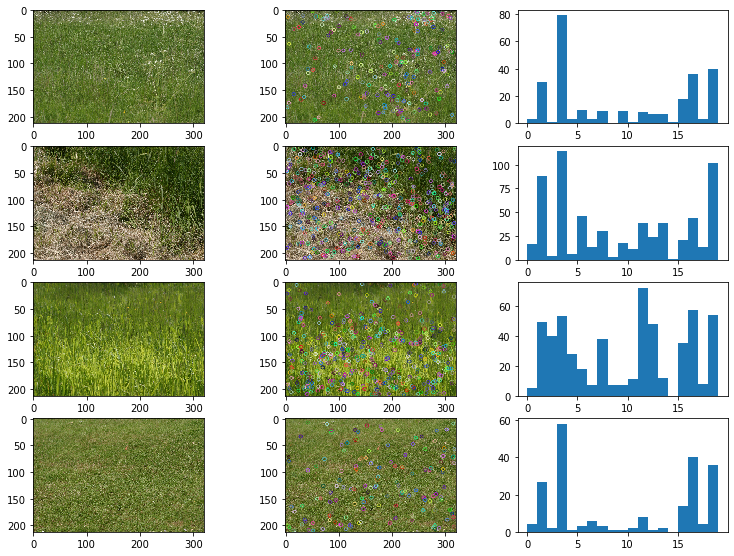

In [65]:
IMAGES_TO_PLOT = 4
train_bovw_representation = codebook.get_bovw_representation()
start_index, end_index = 0, codebook.image_descriptors_lengths[0]
fig, ax = plt.subplots(IMAGES_TO_PLOT, 3, figsize=(12.8, 9.6))
for i in range(IMAGES_TO_PLOT):
  print(f"BOVW representation values: {train_bovw_representation[i]}")
  pil_image = pil_load_image(dir_path, train_images_filenames[i])
  cv2_bgr_image = cv2_load_image(dir_path, train_images_filenames[i])
  cv2_bgr_image = draw_keypoints(cv2_bgr_image, codebook.image_keypoints[i])#, True)
  pil_kp_image, _ = cv2_to_pil(cv2_bgr_image)
  ax[i, 0].imshow(pil_image, interpolation='nearest', cmap='gray')
  ax[i, 1].imshow(pil_kp_image, interpolation='nearest', cmap='gray')
  ax[i, 2].hist(codebook.labels[start_index:end_index], np.arange(N_CLUSTERS))
  # Update indexes
  start_index += codebook.image_descriptors_lengths[i]
  if i < IMAGES_TO_PLOT - 1:
    end_index += codebook.image_descriptors_lengths[i+1]
plt.show()

#### 4. Test the KMeans for new images
We now need to test that the `codebook` is capable of giving this `BOVW` representation also for new images. In the `Codebook` class, we have implemented the `get_cluster_indexes()` method, which will convert a matrix of SIFT descriptors into the corresponding cluster centers indexes. Let's test it with a few test images:

#### 5. Building and training the `LDA`
Now that we have our `codebook` and that we can 

#### 6. Inference with `LDA`

## TODO
### Notes
Below there is code for experimenting with SIFT, BOW etc

### TODOs

1.    Describe BOVW model
2.    Use SIFT to extract features
3.    Implement sampling from the dataset (want to have reproducible experiments)
4.    Use KMeans for clustering for different values of $k$
5.    Take $k$ centers as prototypes for classifying features in images
6.    Convert the images into histograms/sequences of words and feed them to the LDA (train LDA)
7.    Save model (?)
8.    At test phase, use `LDA.transform(<data>)` to get global and word topics of a given image (document)
9.    Plot the results for different runs and values of $k$
10.   Analyze results
11.   Write conclusions